In [1]:
pip install geopandas

In [2]:
pip install k-means-constrained

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from k_means_constrained import KMeansConstrained

In [4]:
!git clone https://github.com/Aleboul/missing/

fatal: destination path 'missing' already exists and is not an empty directory.


In [5]:
data = pd.read_csv('missing/fig_5/data/data.csv', index_col=0)
coord = pd.read_csv("missing/fig_5/data/coordinates.csv", index_col = 0)
gdf = gpd.read_file("missing/fig_5/data/canada.geo.json")

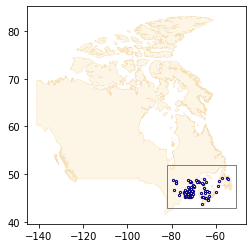

In [6]:
fig, ax = plt.subplots()
gdf.plot(linewidth= 0.4, ax =ax, color = "oldlace", edgecolor = "wheat")
ax.scatter(coord['longitude'], coord['latitude'], s = 5, edgecolor = 'darkblue', color = 'wheat')
plt.gca().add_patch(Rectangle((-82,43),31,9,
                    edgecolor='gray',
                    facecolor='none',
                    lw=1))

(43.0, 52.0)

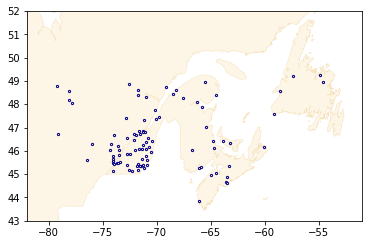

In [7]:
fig, ax = plt.subplots()
gdf.plot(linewidth= 0.4, ax =ax, color = "oldlace", edgecolor = "wheat")
ax.scatter(coord['longitude'], coord['latitude'], s = 5, edgecolor = 'darkblue', color = 'wheat')
ax.set_xlim(-82, -51)
ax.set_ylim(43, 52)

In [8]:
data = data.drop(index = 29, axis = 0)
data = data.drop(index = 7, axis = 0)
data = data.drop(index = 14, axis = 0)
data = data.drop(index = 6, axis = 0)

In [9]:
sort_data = data.isnull().sum(axis = 1).sort_values()

nb = 91 # 90
size = 7 # 
nb_clst = nb // size

x = np.array(sort_data[0:nb].index)

cmap = sns.color_palette("Paired")
X = coord.loc[x]

clf = KMeansConstrained(
     n_clusters= nb_clst,
     size_min=size,
     size_max=size,
     random_state=0
)

clf.fit_predict(X)

array([ 4,  1,  1,  4,  4,  1,  5,  6,  0,  1,  1,  8, 10,  7,  7,  4,  2,
        3,  5, 10, 12,  9, 11,  3, 12,  6,  9,  8, 11, 12,  2,  8,  9,  6,
        5,  6,  2,  9, 11,  9,  3,  3,  7,  2,  4,  6,  5,  0, 10,  9, 10,
        6, 12,  5,  2,  0,  8,  1,  0, 10,  8,  6,  3,  5, 11, 10, 11, 11,
        1,  0, 10,  8,  0,  9, 12,  7,  8,  4,  0,  7,  5,  2, 11,  7,  7,
        3,  2, 12,  3, 12,  4], dtype=int32)

In [10]:
def _ecdf(data, miss):
    """Compute uniform ECDF.

        Inputs
        ------
            data (list([float])) : array of observations.

        Output
        ------
            Empirical uniform margin.
    """
    index = np.argsort(data)
    ecdf  = np.zeros(len(index))
    for i in index:
        ecdf[i] = (1.0 / (1.0+np.sum(miss))) * np.sum((data <= data[i]) * miss)
    return ecdf

def _wmado(X, miss, w,corr = {False, True}) :
    """
        This function computes the w-madogram

        Inputs
        ------
        X (array([float]) of n_sample \times d) : a matrix
                                              w : element of the simplex
                            miss (array([int])) : list of observed data
                           corr (True or False) : If true, return corrected version of w-madogram
        
        Outputs
        -------

        w-madogram
    """
    Nnb = X.shape[1]
    Tnb = X.shape[0]
    V = np.zeros([Tnb, Nnb])
    cross = np.ones(Tnb)
    for j in range(0, Nnb):
        
        cross *= miss[:,j]
        X_vec = np.array(X[:,j])
        Femp = _ecdf(X_vec, miss[:,j])
        V[:,j] = np.power(Femp, 1/w[j])
    V *= cross.reshape(Tnb,1)
    if corr == True:
        value_1 = np.amax(V,1)
        value_2 = (1/Nnb) * np.sum(V, 1)
        value_3 = (Nnb - 1)/Nnb * np.sum(V*w,1)
        return (1/np.sum(cross)) * np.sum(value_1 - value_2 - value_3) + ((Nnb-1)/Nnb)*np.sum(w * w/(1+w))
    else :
        value_1 = np.amax(V,1)
        value_2 = (1/Nnb) * np.sum(V, 1)
        mado = (1/(np.sum(cross))) * np.sum(value_1 - value_2)
    return mado

def Pickands(X, miss, w, corr = True):
    Nnb = X.shape[1]
    mado = _wmado(X,miss, w, corr)
    c = (1/Nnb)*np.sum(np.divide(w, 1 + np.array(w)))
    value = (mado + c) / (1-mado-c)
    return value

In [11]:
data_array = data.loc[x,:]

output = []
for label in np.unique(clf.labels_):
    group = np.array(np.where(clf.labels_ == label))[0]
    group = np.array(data_array.index[group])
    sub_data = np.transpose(np.array(data_array.loc[group,:]))
    miss = 1 * (sub_data >= 0)
    sum_cross = len(np.where(miss.sum(axis = 1) == size)[0]) # sum(cross), common data
    d = sub_data.shape[1]
    w = np.repeat(1/d, d)
    if sum_cross >= 10.0:
        value = d*Pickands(sub_data, miss, w = w, corr = True)
        output.append([group, value])

output = pd.DataFrame(output)
output.columns = ['cluster', 'extremal_coeff']
print(output)

                        cluster  extremal_coeff
0  [85, 73, 87, 86, 88, 89, 74]        5.069497
1  [45, 41, 57, 42, 39, 37, 56]        4.623806
2  [35, 36, 30, 24, 40, 54, 25]        4.759018
3  [83, 53, 43, 55, 60, 59, 66]        4.068591
4   [78, 77, 81, 82, 5, 72, 76]        5.056381
5  [63, 64, 58, 84, 31, 23, 44]        3.877631
6  [62, 46, 61, 65, 38, 52, 47]        3.937566


(43.0, 52.0)

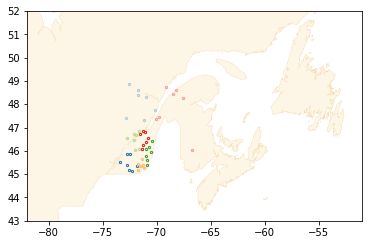

In [12]:
fig, ax = plt.subplots()
gdf.plot(linewidth= 0.4, ax =ax, color = "oldlace", edgecolor = "wheat")
for i,cluster in enumerate(output['cluster']):
    for index in cluster:
        ax.scatter(X.loc[index][1], X.loc[index][0], edgecolor = cmap[i], s = 5, color = 'wheat')

ax.set_xlim(-82, -51)
ax.set_ylim(43, 52)

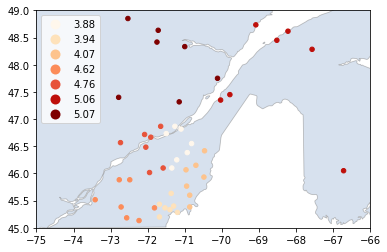

In [13]:
df = []
for i,cluster in enumerate(output['cluster']):
    for index in cluster:
        df.append([index,round(output['extremal_coeff'][i],2), coord.loc[index][0], coord.loc[index][1]])

df = pd.DataFrame(df)
df.columns = ['index', 'ext_coeff', 'latitude', 'longitude']


df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.longitude, df.latitude))
df = df.set_crs(4326, allow_override = True)
fig, ax = plt.subplots()
ax.set_xlim(-75, -66)
ax.set_ylim(45, 49)
gdf.plot(linewidth= 0.8, ax =ax, color = "lightsteelblue", edgecolor = "grey", alpha = 0.5)
df.plot(ax = ax,column = "ext_coeff", cmap = "OrRd",s = 20, categorical = True,legend = True)